In [61]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocossessing

## Dataset

In [62]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
print(coco_path)

/Users/mikey/.fastai/data/coco_sample/train_sample


In [63]:

paths = glob.glob(coco_path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

8000 2000


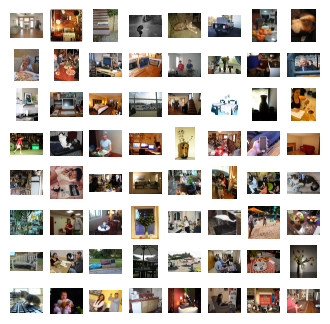

In [64]:
_, axes = plt.subplots(8, 8, figsize=(4, 4))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

**Custom PyTorch Dataset**

In [65]:
import os
import pandas as pd
from torchvision.io import read_image

class ColorizationDataset(Dataset):
    def __init__(self, img_paths, size= (256, 256), train=True ):
        self.paths = img_paths
        self.size = size
        if train == True:
            self.split = 'train'
            self.transform = transforms.Compose([
                transforms.Resize(self.size,  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        else:
            self.split = 'val'
            self.transform = transforms.Resize(self.size,  Image.BICUBIC)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transform(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = (img_lab[[0], ...] / 50.) - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}



## Dataloader

In [66]:
# create train and val datasets
train_ds = ColorizationDataset(img_paths=train_paths)
val_ds = ColorizationDataset(img_paths=val_paths, train=False)

# batch data
train_dl = DataLoader(train_ds, batch_size = 16, num_workers=4, pin_memory=True,)
val_dl = DataLoader(val_ds, batch_size = 16, num_workers=4, pin_memory=True,)

# check data shape
data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
500 125


# GAN Architecture

## Generator

### UNET
* **Input**: 1x256x256 grayscale image. L from [L * a * b] colorspace.  
* **Output**: 3X256x26 in [L * a * b]  

In [67]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Downsampling layers
        self.down1 = nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)
        self.down2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.down3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.down4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.down5 = nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1)

        # Upsampling layers
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.up5 = nn.ConvTranspose2d(64, 2, kernel_size=4, stride=2, padding=1)

        # Activation functions and batch norm
        self.relu = nn.ReLU(True)
        self.leaky_relu = nn.LeakyReLU(0.2, True)
        self.batchnorm64 = nn.BatchNorm2d(64)
        self.batchnorm128 = nn.BatchNorm2d(128)
        self.batchnorm256 = nn.BatchNorm2d(256)
        self.batchnorm512 = nn.BatchNorm2d(512)

    def forward(self, x):
        # Downsample
        d1 = self.leaky_relu(self.batchnorm64(self.down1(x)))
        d2 = self.leaky_relu(self.batchnorm128(self.down2(d1)))
        d3 = self.leaky_relu(self.batchnorm256(self.down3(d2)))
        d4 = self.leaky_relu(self.batchnorm512(self.down4(d3)))
        d5 = self.leaky_relu(self.down5(d4))  # bottleneck

        # Upsample
        u1 = self.relu(self.up1(d5))
        u2 = self.relu(self.batchnorm256(self.up2(u1 + d4)))  # skip connection
        u3 = self.relu(self.batchnorm128(self.up3(u2 + d3)))  # skip connection
        u4 = self.relu(self.batchnorm64(self.up4(u3 + d2)))  # skip connection
        u5 = torch.tanh(self.up5(u4 + d1))  # skip connection

        return u5

### Test Model Output

In [68]:
#test the shape of model output
generator = UNet()
dummy_input = torch.randn([4, 1, 256, 256]) # batch_size, channels, size, size
out = generator(dummy_input)
out.shape # Expected output [4, 2, 256, 256]

torch.Size([4, 2, 256, 256])

# Discriminator

In [69]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 4, stride = 2)
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 4, stride = 2)
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 4, stride = 2)
        self.conv4 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 4, stride = 2)
        self.conv5 = nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 4, stride = 2)
        self.conv6 = nn.Conv2d(in_channels = 1024, out_channels = 1, kernel_size = 4, stride = 1)

        self.fc1 = nn.Linear(9, 1)

        self.batchnorm64 = nn.BatchNorm2d(64)
        self.batchnorm128 = nn.BatchNorm2d(128)
        self.batchnorm256 = nn.BatchNorm2d(256)
        self.batchnorm512 = nn.BatchNorm2d(512)
        self.batchnorm1024 = nn.BatchNorm2d(1024)

        self.leaky_relu = nn.LeakyReLU(0.2, True)

    def forward(self, x):
        x = self.leaky_relu(self.batchnorm64(self.conv1(x)))
        x = self.leaky_relu(self.batchnorm128(self.conv2(x)))
        x = self.leaky_relu(self.batchnorm256(self.conv3(x)))
        x = self.leaky_relu(self.batchnorm512(self.conv4(x)))
        x = self.leaky_relu(self.batchnorm1024(self.conv5(x)))

        x = self.conv6(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)

        x = torch.sigmoid(x)

        return x

In [70]:
# Testing PatchGAN Discriminator
discriminator = Discriminator()
dummy_input = torch.randn(4, 3, 256, 256)  # batch_size=4, channels=3, image_size=256x256
output = discriminator(dummy_input)
print(output.shape)  # Expected output: (4, 1)

torch.Size([4, 1])


## PatchDicriminator

In [71]:
import torch
import torch.nn as nn

class PatchDiscriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(PatchDiscriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),  # (N, 64, H/2, W/2)
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # (N, 128, H/4, W/4)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # (N, 256, H/8, W/8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # (N, 512, H/16, W/16)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),  # (N, 1, H/16 - 3, W/16 - 3)
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)




In [72]:
# Testing PatchGAN Discriminator
discriminator = PatchDiscriminator()
dummy_input = torch.randn(4, 3, 256, 256)  # batch_size=4, channels=3, image_size=256x256
output = discriminator(dummy_input)
print(output.shape)  # Expected output: (4, 1, 13, 13)

torch.Size([4, 1, 13, 13])


## Perceptual Loss

In [73]:
class PerceptualLoss():
    pass #TBD

# Training

## Hyperparameters

In [74]:
# Assuming UNet is already defined as per the code above
generator = UNet()
discriminator = Discriminator()

# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

# Loss functions
adversarial_loss = nn.BCELoss()  
l1_loss = nn.L1Loss()
lambda_L1 = 0.001

# Optimizers
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

opt_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
opt_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

# training params
num_epochs = 200
batch_size = 16

### Intialize Models

In [76]:
def init_model(model):
    #TBD
    return model

G_net = init_model(generator)
D_net = init_model(discriminator)


In [77]:
# Function to set requires_grad
def set_requires_grad(model, requires_grad=True):
    for p in model.parameters():
        p.requires_grad = requires_grad

## Training Loop

In [78]:
for epoch in range(num_epochs):
    for i, data in enumerate(train_dl):  # dataloader provides batches of L (grayscale) and ab (color)
        
        # Setup input data and move to appropriate device (GPU/CPU)
        L = data['L'].to(device)
        ab = data['ab'].to(device)

        # Adversarial ground truths
        batch_size = L.size(0)  # Get the batch size
        valid = torch.ones((batch_size, 1), requires_grad=False).to(device)
        fake = torch.zeros((batch_size, 1), requires_grad=False).to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        D_net.train()
        set_requires_grad(D_net, True)
        opt_D.zero_grad()

        # Forward pass: create fake images from the generator
        fake_color = D_net(L)
        fake_image = torch.cat([L, fake_color], dim=1)  # Combine L channel and generated ab channels
        real_image = torch.cat([L, ab], dim=1)  # Combine L channel and real ab channels

        # Discriminator loss for fake images
        fake_preds = D_net(fake_image.detach())
        loss_D_fake = adversarial_loss(fake_preds, False)  # Fake labels for generated images

        # Discriminator loss for real images
        real_preds = D_net(real_image)
        loss_D_real = adversarial_loss(real_preds, True)  # Real labels for real images

        # Total discriminator loss and backpropagation
        loss_D = (loss_D_fake + loss_D_real) * 0.5
        loss_D.backward()
        opt_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        G_net.train()
        set_requires_grad(D_net, False)  # Freeze discriminator weights while training generator
        opt_G.zero_grad()

        # Forward pass: generate fake images
        fake_color = G_net(L)
        fake_image = torch.cat([L, fake_color], dim=1)

        # Generator adversarial loss (fooling the discriminator)
        fake_preds = D_net(fake_image)
        loss_G_GAN = adversarial_loss(fake_preds, True)

        # Generator L1 loss (reconstruction loss)
        loss_G_L1 = l1_loss(fake_color, ab) * lambda_L1

        # Total generator loss and backpropagation
        loss_G = loss_G_GAN + loss_G_L1
        loss_G.backward()
        opt_G.step()

        # Print losses or store them for monitoring
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_dl)}], "
                  f"D Loss: {loss_D.item():.4f}, G Loss: {loss_G.item():.4f}")

RuntimeError: Given groups=1, weight of size [64, 3, 4, 4], expected input[16, 1, 256, 256] to have 3 channels, but got 1 channels instead

In [ ]:
class GAN_train():
    def __init__(self):
        self.adversarial_loss
        if gen_loss == 'L1':
            self.generator_loss = nn.L1Loss
        else:
            self.generator_loss = PerceptualLoss()